## Training ResNext for Cassava Leaf Disease Classification

## Importing Libraries

In [1]:
!pip install pytorch-lightning --quiet
!pip install torch_snippets --quiet
!pip uninstall albumentations -y --quiet
!pip install albumentations --quiet
!pip install timm --quiet

In [2]:
import os
import cv2
import timm
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchmetrics as tm
import pytorch_lightning as pl
import albumentations as A

from albumentations.pytorch import ToTensorV2
from torch_snippets import *
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

import warnings

warnings.simplefilter('ignore')

2021-07-03 15:57:32.429 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


## Configuration

In [3]:
def seed_everything(seed=1234):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deteministic = True

seed_everything(1234)

In [4]:
class Config:

  INPUT_PATH = '/content/drive/MyDrive/Projects/Casava_Leaf_Disease_Classification/input'
  DATA = INPUT_PATH + '/train.csv'
  IMAGE_PATH = INPUT_PATH + '/train_images'

  DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  IMAGE_HEIGHT = 256
  IMAGE_WIDTH = 256

  TRAIN_BATCH_SIZE = 32
  VALID_BATCH_SIZE = 32

  MODEL_NAME = 'resnext50_32x4d'
  NUM_CLASSES = 5

  PATIENCE = 5
  NUM_EPOCHS = 10
  LR = 0.0001
  WEIGHT_DECAY = 0.00005


In [5]:
config = Config()

In [6]:
df = pd.read_csv(config.DATA)
df.head(2)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3


In [7]:
len(df)

21397

## Creaing the Dataset

In [8]:
present = []

for image_id in df['image_id'].values:
  path = config.IMAGE_PATH + '/' + image_id
  if os.path.exists(path):
    present.append(image_id)

In [9]:
print("Images present in the Dataset and also in metadata", len(present))

Images present in the Dataset and also in metadata 20068


In [10]:
df = df[df['image_id'].isin(present)]
df.head(2)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3


In [11]:
class TrainDataset(Dataset):

  def __init__(self, df, config, transforms=None):
    self.df = df
    self.image_ids = self.df['image_id'].values
    self.labels = self.df['label'].values
    self.transforms = transforms
    self.config = config

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    image_path = self.config.IMAGE_PATH + '/' + image_id
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transforms:
      image = self.transforms(image=image)['image']

    label = self.labels[idx]
    return image, label

In [12]:
class TestDataset(Dataset):
  
  def __init__(self, df, config, transforms=None):
    self.df = df
    self.image_ids = self.df['image_id'].values
    self.labels = self.df['label'].values
    self.transforms = transforms
    self.config = config

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    image_path = self.config.IMAGE_PATH + '/' + image_id
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transforms:
      image = self.transforms(image=image)['image']

    label = self.labels[idx]
    return image, label

## Creating Augmentation Pipline

In [13]:
def get_train_transforms():

  return A.Compose([
            A.RandomResizedCrop(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.Normalize(),
            ToTensorV2(),
  ])

def get_valid_transforms():

  return A.Compose([
                    A.Resize(config.IMAGE_HEIGHT, config.IMAGE_WIDTH, always_apply=True, p=1.0),
                    A.Normalize(),
                    ToTensorV2(always_apply=True, p=1.0)
  ])

## Splitting the dataset

In [14]:
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=1234)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [15]:
df_train.head(2)

,image_id,label
0,2070373158.jpg,3
1,1514398511.jpg,3


In [16]:
df_test.head(2)

,image_id,label
0,439915243.jpg,3
1,3847675023.jpg,4


In [17]:
train_dataset = TrainDataset(df_train, config, get_train_transforms())
valid_dataset = TestDataset(df_test, config, get_valid_transforms())

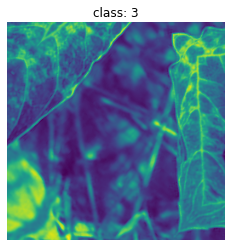

In [18]:
image, label = train_dataset[0]
plt.imshow(image[0])
plt.title(f'class: {label}')
plt.axis('off');

## Creating the DataLoader

In [19]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=config.TRAIN_BATCH_SIZE,
                              shuffle=False,
                              num_workers=8,
                              pin_memory=True,
                              )

In [20]:
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=config.VALID_BATCH_SIZE,
                              shuffle=False,
                              num_workers=8,
                              pin_memory=True)

## Creating the model class

In [21]:
class Classifier(nn.Module):

  def __init__(self, config, pretrained=False):
    super(Classifier, self).__init__()
    self.model = timm.create_model(config.MODEL_NAME, pretrained=pretrained)
    n_features = self.model.fc.in_features
    self.model.fc = nn.Linear(n_features, Config.NUM_CLASSES)

  def forward(self, x):
    return self.model(x)

## Creating Helper/Training Functions

In [22]:
def train_batch(inputs, model, criterion, optimizer):
  
  model.train()

  images, labels = inputs

  images = images.to(config.DEVICE)
  labels = labels.to(config.DEVICE)

  outputs = model(images)

  optimizer.zero_grad()
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()

  return loss.item()

In [23]:
def valid_batch(inputs, model, criterion):

  model.eval()

  images, labels = inputs
  images = images.to(config.DEVICE)
  labels = labels.to(config.DEVICE)
  
  with torch.no_grad():
    outputs = model(images)
    loss = criterion(outputs, labels)

  return loss.item(), outputs

In [24]:
torch.cuda.empty_cache()
model = Classifier(config, pretrained=True)
model.to(config.DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.LR, weight_decay=config.WEIGHT_DECAY)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=config.PATIENCE)
metric = tm.AUROC(num_classes=config.NUM_CLASSES).to(config.DEVICE)
log = Report(config.NUM_EPOCHS)

## Training the Model

In [25]:
for epoch in range(config.NUM_EPOCHS):

  epoch_train_loss = 0
  epoch_valid_loss = 0
  valid_preds = []
  valid_targets = []

  for idx, inputs in enumerate(train_dataloader):
    
    loss = train_batch(inputs, model, criterion, optimizer)
    epoch_train_loss += loss

    log.record(epoch + (idx+1)/len(train_dataloader), 
               train_loss = epoch_train_loss/(idx+1),
               end = '\r')

  for idx, inputs in enumerate(valid_dataloader):

    loss, preds = valid_batch(inputs, model, criterion)
    epoch_valid_loss += loss
    valid_preds.append(F.softmax(preds))
    valid_targets.append(inputs[1])

    log.record(epoch + (idx+1)/len(valid_dataloader), 
               valid_loss = epoch_valid_loss/(idx+1),
               end = '\r')

  schedular.step(epoch_valid_loss/len(valid_dataloader))

EPOCH: 10.000	valid_loss: 0.464	(3094.23s - 0.00s remaining)

100%|██████████| 111/111 [00:00<00:00, 563.15it/s]


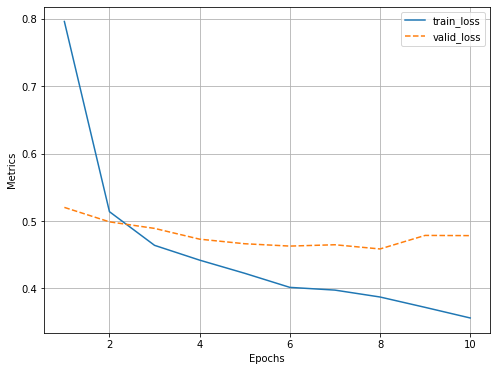

In [27]:
log.plot_epochs()

## Observations:


*   The model has been succesfully trained with the final validation loss of 0.464
*   There is some observable overfitting in the model and hence early stopping could be or great use or could regularize the model.



In [26]:
# Let's save the model

torch.save(model.state_dict(), f'{config.INPUT_PATH}/model.bin')

## Calculating the Metric

In [35]:
preds = []
ground_truths = []

for idx, inputs in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):

  images, labels = inputs
  images = images.to(config.DEVICE)
  outputs = F.softmax(model(images)).detach().cpu().numpy()

  preds.append(outputs)
  ground_truths.append(labels)

In [44]:
final_preds = []
final_gts = []

for i, j in zip(preds, ground_truths):
  for x, y in zip(i, j):
    final_preds.append(x)
    final_gts.append(y)

In [48]:
final_preds = torch.tensor(final_preds)
final_gts = torch.tensor(final_gts)
metric(final_preds, final_gts)

tensor(0.9580)

## Conclusion:
We have a very good ROC Score of 0.958 on validation set which shows that our model performs well.